**Task:**   
Predict the price of U.S. AirBnB rentals.     
Evaluate the solution with reproduceable low root-mean-squared error (RMSE) based on cross-validation.   

**Data:**   
As of October 2020, the dataset has 226030 rows and 17 columns of Airbnb listings in the U.S.   
The dataset includes NaNs, and data is of mixed types.   

The average price is about $219.72.   
Minimum night averages between 4 and 5.  
There are 4 categories of room type: Entire home/apt, Private room, Shared room, and Hotel room. 

There is minimal correlation between price and other columns in the dataset.   

Added a column (state). Grouped prices into ranges to improve model performance.   

**Models:**   
Linear and multple linear regressions did not perform well for this datase.   
KNN regression performed better and so did decision tree.   
KNN classifier performed best.   







Expected Submission   
Users should submit a CSV file with each listing from the data set and the model-predicted price:   

id, price   
49091, 83   
50646, 81   
56334, 69   
...   


In [1]:
# Python 3 environment with analytics libraries installed
# as defined by the kaggle/python Docker 

import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/us-airbnb-open-data/AB_US_2020.csv


In [2]:
#other libraries for math and plotting
import seaborn as sns

import statsmodels.api as sm

import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt

#map plotting libraries
import folium
from folium import plugins
from folium.plugins import HeatMap

#ML models
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

#ignore error messages
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")    
    

In [3]:
df1=pd.read_csv("../input/us-airbnb-open-data/AB_US_2020.csv")
df1

id                                               name  \
0          38585    Charming Victorian home - twin beds + breakfast   
1          80905                                   French Chic Loft   
2         108061  Walk to stores/parks/downtown. Fenced yard/Pet...   
3         155305                 Cottage! BonPaul + Sharky's Hostel   
4         160594                                Historic Grove Park   
...          ...                                                ...   
226025  45506143                          DC Hidden In Plain "Site"   
226026  45511428  DC 3 BR w/ screen porch 3 blck to metro w/ par...   
226027  45514685  Charming Penthouse Apt w/ Rooftop Terrace in L...   
226028  45516412                Adams Morgan/Nat'l Zoo 1 BR Apt #32   
226029  45517735    Beautiful large one-bedroom w/ washer and dryer   

          host_id  host_name neighbourhood_group  \
0          165529    Evelyne                 NaN   
1          427027    Celeste                 NaN   
2          320564       Lisa                 NaN   
3          746673    BonPaul                 NaN   
4          769252  Elizabeth                 NaN   
...           ...        ...                 ...   
226025   25973146      Marci                 NaN   
226026  231133074     Thomas                 NaN   
226027   33758935     Bassem                 NaN   
226028   23193071    Michael                 NaN   
226029   17789858       Adam                 NaN   

                                            neighbourhood   latitude  \
0                                                   28804  35.651460   
1                                                   28801  35.597790   
2                                                   28801  35.606700   
3                                                   28806  35.578640   
4                                                   28801  35.614420   
...                                                   ...        ...   
226025  Downtown, Chinatown, Penn Quarters, Mount Vern...  38.903880   
226026                      Brookland, Brentwood, Langdon  38.920820   
226027                                 Shaw, Logan Circle  38.911170   
226028     Kalorama Heights, Adams Morgan, Lanier Heights  38.926630   
226029  Edgewood, Bloomingdale, Truxton Circle, Eckington  38.911569   

        longitude        room_type  price  minimum_nights  number_of_reviews  \
0      -82.627920     Private room     60               1                138   
1      -82.555400  Entire home/apt    470               1                114   
2      -82.555630  Entire home/apt     75              30                 89   
3      -82.595780  Entire home/apt     90               1                267   
4      -82.541270     Private room    125              30                 58   
...           ...              ...    ...             ...                ...   
226025 -77.029730  Entire home/apt    104               1                  0   
226026 -76.990980  Entire home/apt    151               2                  0   
226027 -77.033540  Entire home/apt    240               2                  0   
226028 -77.044360  Entire home/apt     60              21                  0   
226029 -77.009431  Entire home/apt     79               7                  0   

       last_review  reviews_per_month  calculated_host_listings_count  \
0         16/02/20               1.14                               1   
1         07/09/20               1.03                              11   
2         30/11/19               0.81                               2   
3         22/09/20               2.39                               5   
4         19/10/15               0.52                               1   
...            ...                ...                             ...   
226025         NaN                NaN                               2   
226026         NaN                NaN                               1   
226027         NaN                NaN                

In [4]:
#how many NaNs in the dataset?
df1.isnull().sum().sum()

213110

In [5]:
df1.name.isnull().sum().sum()

28

In [6]:
df1.host_name.isnull().sum().sum()

33

In [7]:
df1.reviews_per_month.isnull().sum().sum()

48602

In [8]:
##replace the NaNs in some columns
df1[['name', 'host_name']] = df1[['name', 'host_name']].fillna(value='None')

In [9]:
#replace NaNs with 0s
df1[['reviews_per_month']] = df1[['reviews_per_month']].fillna(value=0)

In [10]:
#over 100,000 entries are NaN in this column
df1.neighbourhood_group.isnull().sum().sum()

115845

In [11]:
#missing dates
df1.last_review.isnull().sum().sum()

48602

In [12]:
#dropped 2 columns with several NaNs
df2=df1.drop(['neighbourhood_group', 'last_review'], axis=1)

Added a new colunm: State

In [13]:
# create a list of our conditions
conditions = [
    (df2['city'] == 'New York City'),
    (df2['city'] == 'Columbus'),
    (df2['city'] == 'Hawaii'),
    (df2['city'] == 'Asheville'),
     (df2['city'] == 'Jersey City'),
    
     (df2['city'] == 'Washington D.C.'),
    (df2['city'] == 'Clark County'),
     (df2['city'] == 'Rhode Island'),
     (df2['city'] == 'Portland'),
     (df2['city'] == 'Austin'),
    
    (df2['city'] == 'Broward County'),
    (df2['city'] == 'Seattle'),
    (df2['city'] == 'Twin Cities MSA'),
    (df2['city'] == 'New Orleans'),
    
    (df2['city'] == 'Chicago'),
    (df2['city'] == 'Nashville'),
    (df2['city'] == 'Denver'),
        
    (df2['city'] == 'Cambridge') | (df2['city'] == 'Boston') | (df2['city'] == 'Salem'),
    
    (df2['city'] == 'Los Angeles') | (df2['city'] == 'Oakland') | (df2['city'] == 'San Diego') |
    (df2['city'] == 'San Francisco') | (df2['city'] == 'Santa Cruz County') |
    (df2['city'] == 'Pacific Grove')| (df2['city'] == 'San Clara Country') | (df2['city'] == 'San Mateo County')
    ]

# create a list of the values we want to assign for each condition
values = ['NY', 'OH', 'HI', 'NC', 'NJ',
          'DC', 'NV', 'RI', 
          'OR', 'TX', 'FL','WA', 
          'MN', 'LA', 'IL', 'TN',
         'CO', 'MA', 'CA']

# create a new column and use np.select to assign values to it using our lists as arguments
df2['state'] = np.select(conditions, values)

# display updated DataFrame
df2.head()

id                                               name  host_id  \
0   38585    Charming Victorian home - twin beds + breakfast   165529   
1   80905                                   French Chic Loft   427027   
2  108061  Walk to stores/parks/downtown. Fenced yard/Pet...   320564   
3  155305                 Cottage! BonPaul + Sharky's Hostel   746673   
4  160594                                Historic Grove Park   769252   

   host_name neighbourhood  latitude  longitude        room_type  price  \
0    Evelyne         28804  35.65146  -82.62792     Private room     60   
1    Celeste         28801  35.59779  -82.55540  Entire home/apt    470   
2       Lisa         28801  35.60670  -82.55563  Entire home/apt     75   
3    BonPaul         28806  35.57864  -82.59578  Entire home/apt     90   
4  Elizabeth         28801  35.61442  -82.54127     Private room    125   

   minimum_nights  number_of_reviews  reviews_per_month  \
0               1                138               1.14   
1               1                114               1.03   
2              30                 89               0.81   
3               1                267               2.39   
4              30                 58               0.52   

   calculated_host_listings_count  availability_365       city state  
0                               1                 0  Asheville    NC  
1                              11               288  Asheville    NC  
2                               2               298  Asheville    NC  
3                               5                 0  Asheville    NC  
4                               1                 0  Asheville    NC

In [14]:
#name is an intro to the property
df2.name.unique()

array(['Charming Victorian home - twin beds + breakfast',
       'French Chic Loft',
       'Walk to stores/parks/downtown. Fenced yard/Pets OK', ...,
       'Charming Penthouse Apt w/ Rooftop Terrace in Logan',
       "Adams Morgan/Nat'l Zoo 1 BR Apt #32",
       'Beautiful large one-bedroom w/ washer and dryer'], dtype=object)

In [15]:
df2.room_type.value_counts()

Entire home/apt    154173
Private room        65887
Shared room          4029
Hotel room           1941
Name: room_type, dtype: int64

In [16]:
df2.describe(include='all')

id                 name       host_id host_name  \
count   2.260300e+05               226030  2.260300e+05    226030   
unique           NaN               218444           NaN     30534   
top              NaN  Home away from home           NaN   Michael   
freq             NaN                   75           NaN      2025   
mean    2.547176e+07                  NaN  9.352385e+07       NaN   
std     1.317814e+07                  NaN  9.827422e+07       NaN   
min     1.090000e+02                  NaN  2.300000e+01       NaN   
25%     1.515890e+07                  NaN  1.399275e+07       NaN   
50%     2.590916e+07                  NaN  5.138266e+07       NaN   
75%     3.772624e+07                  NaN  1.497179e+08       NaN   
max     4.556085e+07                  NaN  3.679176e+08       NaN   

               neighbourhood       latitude      longitude        room_type  \
count                 226030  226030.000000  226030.000000           226030   
unique                  1450            NaN            NaN                4   
top     Unincorporated Areas            NaN            NaN  Entire home/apt   
freq                    8020            NaN            NaN           154173   
mean                     NaN      35.662829    -103.220662              NaN   
std                      NaN       6.849855      26.222091              NaN   
min                      NaN      18.920990    -159.714900              NaN   
25%                      NaN      32.761783    -118.598115              NaN   
50%                      NaN      37.261125     -97.817200              NaN   
75%                      NaN      40.724038     -76.919322              NaN   
max                      NaN      47.734620     -70.995950              NaN   

                price  minimum_nights  number_of_reviews  reviews_per_month  \
count   226030.000000    2.260300e+05      226030.000000      226030.000000   
unique            NaN             NaN                NaN                NaN   
top               NaN             NaN                NaN                NaN   
freq              NaN             NaN                NaN                NaN   
mean       219.716529    4.525490e+02          34.506530           1.123653   
std        570.353609    2.103376e+05          63.602914           1.603074   
min          0.000000    1.000000e+00           0.000000           0.000000   
25%         75.000000    1.000000e+00           1.000000           0.040000   
50%        121.000000    2.000000e+00           8.000000           0.420000   
75%        201.000000    7.000000e+00          39.000000           1.620000   
max      24999.000000    1.000000e+08         966.000000          44.060000   

        calculated_host_listings_count  availability_365           city  \
count                    226030.000000     226030.000000         226030   
unique                             NaN               NaN             28   
top                                NaN               NaN  New York City   
freq                               NaN               NaN          45756   
mean                         16.698562        159.314856            NaN   
std                          51.068966        140.179628            NaN   
min                           1.000000          0.000000            NaN   
25%                           1.000000          0.000000            NaN   
50%                           2.000000        140.000000            NaN   
75%                           6.000000        311.000000            NaN   
max                         593.000000        365.000000            NaN   

         state  
count   226030  
unique      19  
top         CA  
freq     65893  
mean       NaN  
std        NaN  
min        NaN  
25%        NaN  
50%        NaN  
75%        NaN  
max        NaN

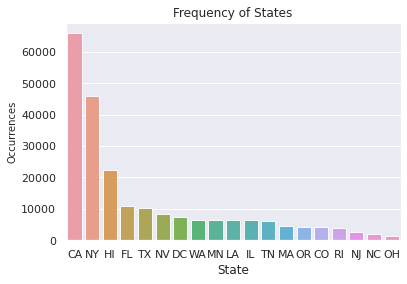

In [17]:
st_count = df2['state'].value_counts()
sns.set(style="darkgrid")
sns.barplot(st_count.index, st_count.values, alpha=0.9)
plt.title('Frequency of States')
plt.ylabel('Occurrences', fontsize=10)
plt.xlabel('State', fontsize=12)
plt.show()

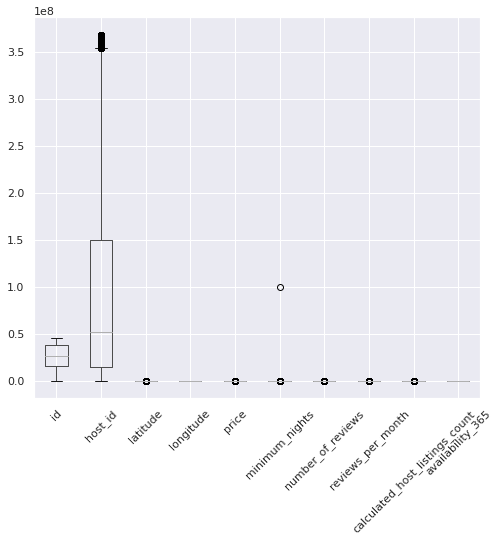

In [18]:
#find possible outliers
#boxplot of columns
boxplot = df2.boxplot(figsize=(8,7),rot=45)

In [19]:
#drop column 'host_id'
df3=df2.drop(['host_id'], axis=1)

<AxesSubplot:>

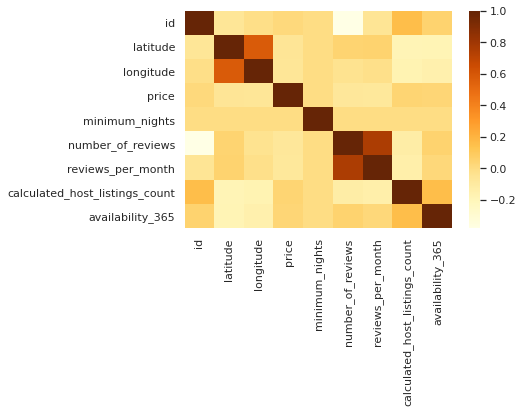

In [20]:
corr1=df3.corr()
sns.heatmap(corr1, cmap="YlOrBr")

<AxesSubplot:title={'center':'Room Type'}>

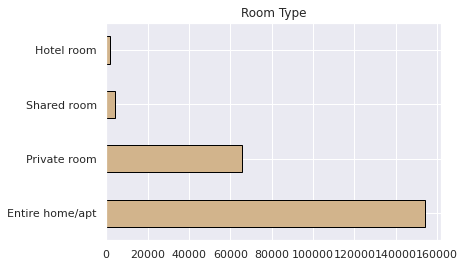

In [21]:
df3['room_type'].value_counts().plot(kind='barh', figsize=(6,4), 
                                     edgecolor=(0,0,0),color='tan', title='Room Type')

<AxesSubplot:title={'center':'State'}>

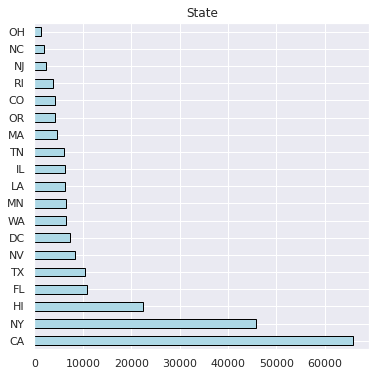

In [22]:
df3['state'].value_counts().plot(kind='barh', figsize=(6,6), 
                                     edgecolor=(0,0,0),color='lightblue', title='State')

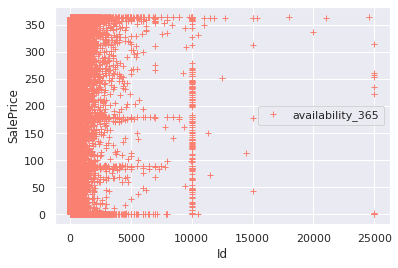

In [23]:
df3.plot(x='price', y='availability_365', style='+', color='salmon')  
plt.xlabel('Id')  
plt.ylabel('SalePrice')  
plt.show()

In [24]:
##map 
#a map of North America
US = folium.Map(location=[54.5260, -105.2551],
                   zoom_start = 3)


# List comprehension to make a list of lists
heat_data = [[row['latitude'],row['longitude']] for index, row in df3.iterrows()]

# Plot it on the map
HeatMap(heat_data).add_to(US)

# Display the map
US

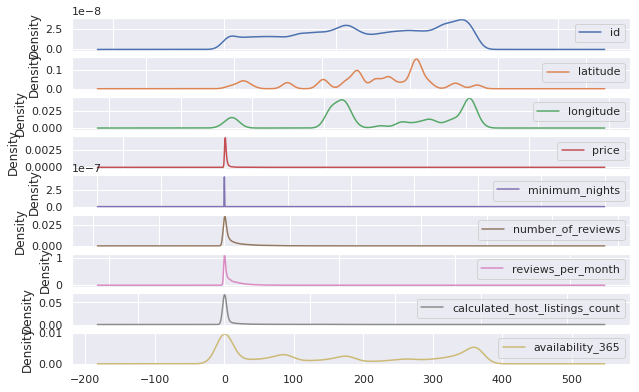

In [25]:
df3.plot(kind='density', subplots=True, layout=(14,1), sharex=False, figsize=(10,10))
plt.show()

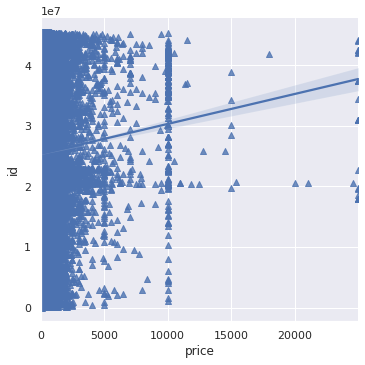

In [26]:
sns.lmplot(x='price', y='id', data=df3, logistic=False,  markers=["^"])

In [27]:
#drop outliers: minimum_nights 31 and higher
df3=df3[df3['minimum_nights'] < 31]
#verify changes
df3.shape

(217035, 15)

### Models and predictions
-**Price** is the desired prediction.

1. Linear Regression

In [28]:
#Linear regression
X = df3['price'].values.reshape(-1,1)
y = df3['availability_365'].values.reshape(-1,1)

In [29]:
#split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

regressor = LinearRegression()  
regressor.fit(X_train, y_train) #train the model

LinearRegression()

In [30]:
#Intercept
print(regressor.intercept_)
#Slope
print(regressor.coef_)

[155.30125894]
[[0.00938507]]


In [31]:
#Predict
y_pred = regressor.predict(X_test)

In [32]:
#actual value and predicted value
dfLinReg = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
dfLinReg

Actual   Predicted
0          68  155.517115
1         335  157.638141
2         365  157.178272
3         200  159.524539
4           1  156.230381
...       ...         ...
86809     119  169.369475
86810       0  156.324231
86811      38  156.052064
86812     339  157.478595
86813     317  162.799928

[86814 rows x 2 columns]

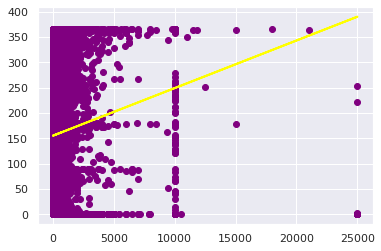

In [33]:
plt.scatter(X_test, y_test,  color='purple')
plt.plot(X_test, y_pred, color='yellow', linewidth=2)
plt.show()

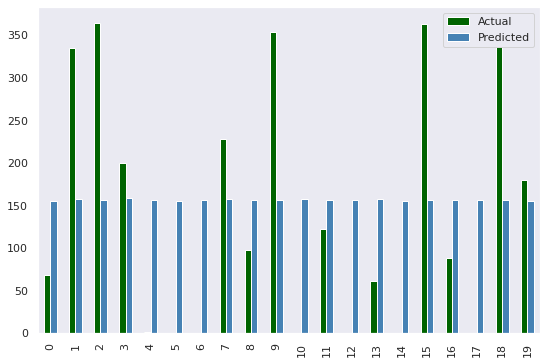

In [34]:
#comparison 
first20preds=dfLinReg.head(20)
c='darkgreen', 'steelblue'
first20preds.plot(kind='bar',figsize=(9,6), color=c)
plt.grid(which='major', linestyle='-', linewidth='0.3', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [35]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 126.14976115747854
Mean Squared Error: 19523.584983640118
Root Mean Squared Error: 139.72682270645146


The above linear regression model is not ideal.   
Changes to test size and random state did not impact the results.

2- Multiple Reression

In [36]:
#Convert to Numeric
# creating instance of labelencoder
labelencoder = LabelEncoder()# Assigning numerical values and storing in another column
df3['room_type_Cat'] = labelencoder.fit_transform(df3['room_type'])
df3['city_Cat'] = labelencoder.fit_transform(df3['city'])
df3['state_Cat'] = labelencoder.fit_transform(df3['state'])
df3.head()

id                                               name  host_name  \
0   38585    Charming Victorian home - twin beds + breakfast    Evelyne   
1   80905                                   French Chic Loft    Celeste   
2  108061  Walk to stores/parks/downtown. Fenced yard/Pet...       Lisa   
3  155305                 Cottage! BonPaul + Sharky's Hostel    BonPaul   
4  160594                                Historic Grove Park  Elizabeth   

  neighbourhood  latitude  longitude        room_type  price  minimum_nights  \
0         28804  35.65146  -82.62792     Private room     60               1   
1         28801  35.59779  -82.55540  Entire home/apt    470               1   
2         28801  35.60670  -82.55563  Entire home/apt     75              30   
3         28806  35.57864  -82.59578  Entire home/apt     90               1   
4         28801  35.61442  -82.54127     Private room    125              30   

   number_of_reviews  reviews_per_month  calculated_host_listings_count  \
0                138               1.14                               1   
1                114               1.03                              11   
2                 89               0.81                               2   
3                267               2.39                               5   
4                 58               0.52                               1   

   availability_365       city state  room_type_Cat  city_Cat  state_Cat  
0                 0  Asheville    NC              2         0          9  
1               288  Asheville    NC              0         0          9  
2               298  Asheville    NC              0         0          9  
3                 0  Asheville    NC              0         0          9  
4                 0  Asheville    NC              2         0          9

In [37]:
#multiple regression

X_ = df3[['calculated_host_listings_count', 'room_type_Cat', 
          'room_type_Cat', 'city_Cat', 'state_Cat']] # multiple variable regression. 
Y = df3['price']
 
# with sklearn
regr = LinearRegression()
regr.fit(X_, Y)

print('Intercept: ', regr.intercept_)
print('Coefficients: ', regr.coef_)

print (regr)

Intercept:  259.5026822256804
Coefficients:  [  0.36287494 -39.46495208 -39.46495208   1.80937401  -2.53634578]
LinearRegression()


In [38]:
y_pred2 = regr.predict(X_)

In [39]:
dfmult= pd.DataFrame({'Actual': Y, 'Predicted': y_pred2.flatten()})
dfmult

Actual   Predicted
0           60   79.178637
1          470  240.667194
2           75  237.401320
3           90  238.489945
4          125   79.178637
...        ...         ...
226025     104  304.008839
226026     151  303.645964
226027     240  303.645964
226028      60  305.097464
226029      79  304.008839

[217035 rows x 2 columns]

In [40]:
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y, y_pred2)))

Root Mean Squared Error: 567.222440183279


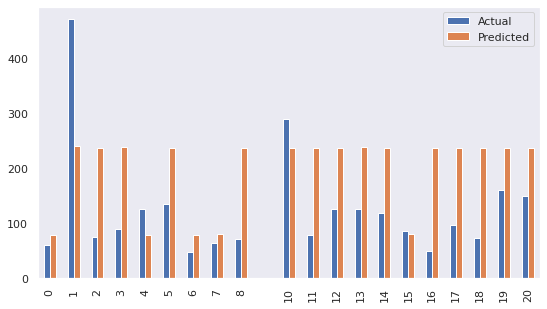

In [41]:
#comparison 
first20preds2=dfmult.head(20)
first20preds2.plot(kind='bar',figsize=(9,5))
plt.grid(which='major', linestyle='-', linewidth='0.3', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

3- KNN

Grouping prices into economic, low-mid, high-mid, and high to improve the model.

In [42]:
# create a list of conditions
conditions = [
    (df3['price'] < 100),
    (df3['price'] >= 100) & (df3['price'] < 250),
     (df3['price'] >= 250) & (df3['price'] < 600),
    (df3['price'] >= 600) ]

# create a list of the values we want to assign for each condition
values = ['economic', 'low-mid', 'high-mid','high']

# create a new column and use np.select to assign values to it using our lists as arguments
df3['price_range'] = np.select(conditions, values)

In [43]:
df3['price_range'].value_counts()

low-mid     88740
economic    85238
high-mid    32124
high        10933
Name: price_range, dtype: int64

In [44]:
labelencoder = LabelEncoder()# Assigning numerical values and storing in another column
df3['price_rng_Cat'] = labelencoder.fit_transform(df3['price_range'])

In [45]:
df4=df3[['id','minimum_nights','availability_365', 
         'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count',
         'room_type_Cat','city_Cat', 'state_Cat', 'price', 'price_rng_Cat']]

In [46]:
df4.corr().style.background_gradient(cmap='magma')

In [47]:
#K-nearest neighbors (KNN)
##Best performing model

neigh = KNeighborsClassifier(n_neighbors=3)

X1=df4.iloc[:, :-1].values
Y1=df4['price_rng_Cat'].values

# Split into training and test  
X_train, X_test, y_train, y_test = train_test_split( 
             X1, Y1, test_size = 0.4, random_state=1) 

#standardize data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#fit the model
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [48]:
# Predicted class
y_pred3=neigh.predict(X_test)

In [49]:
KNNmod = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred3.flatten()})
KNNmod

Actual  Predicted
0           0          0
1           0          0
2           2          2
3           3          3
4           3          3
...       ...        ...
86809       1          1
86810       0          0
86811       3          3
86812       0          0
86813       3          3

[86814 rows x 2 columns]

In [50]:
# Calculate the accuracy of the model 
print(neigh.score(X_test, y_test)) 

0.7736655378164812


In [51]:
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred3)))

Root Mean Squared Error: 1.24237022255802


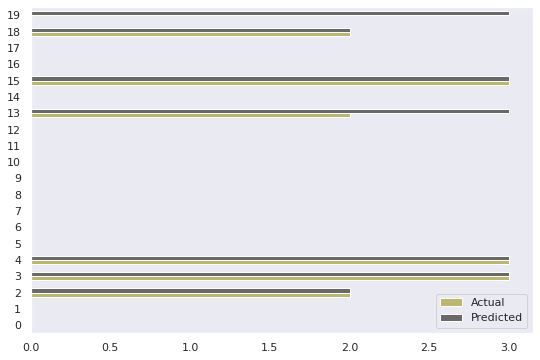

In [52]:
#comparison 
first20preds3=KNNmod.head(20)
c2='darkkhaki', 'dimgray'
first20preds3.plot(kind='barh',figsize=(9,6), color=c2)
plt.grid(which='major', linestyle='-', linewidth='0.3', color='orange')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

The above model did not work with the original price parameters. The changing number of neighbors, test size or random state make insignificant improvement to the **RMSE**.   
The model improve significantly after grouping prices.

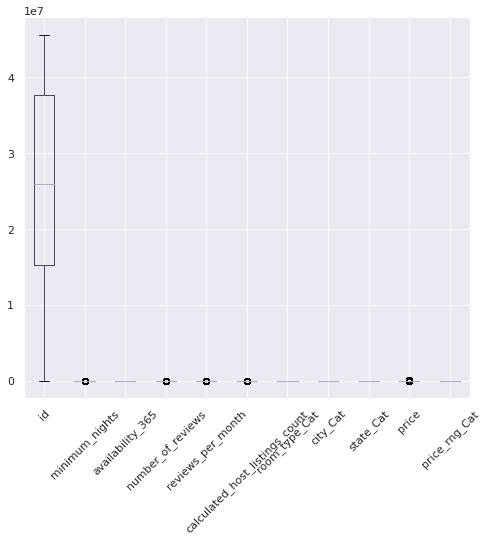

In [53]:
#find possible outliers
#boxplot of columns
boxplot5 = df4.boxplot(figsize=(8,7),rot=45)

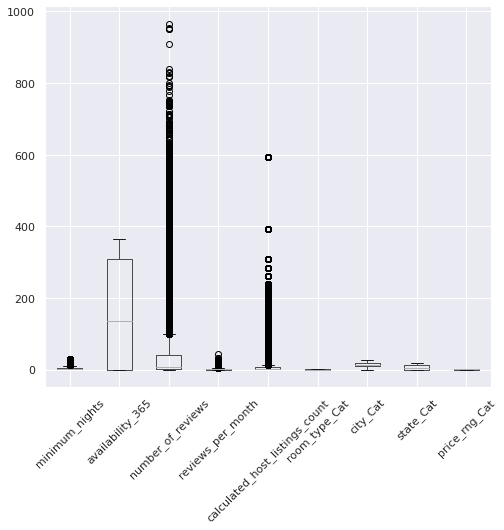

In [54]:
#find possible outliers
#boxplot of columns
boxplot6 = df4.boxplot(column=['minimum_nights', 'availability_365', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count', 'room_type_Cat',
       'city_Cat', 'state_Cat', 'price_rng_Cat'],
                       figsize=(8,7),rot=45)


<AxesSubplot:xlabel='calculated_host_listings_count', ylabel='price_rng_Cat'>

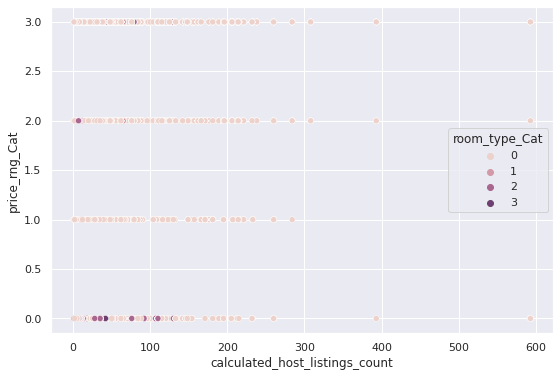

In [55]:
#Scatter plot 
plt.figure(figsize=(9, 6))
sns.scatterplot(
    data=df4, x="calculated_host_listings_count", y="price_rng_Cat", hue="room_type_Cat", 
    sizes=(10, 200), hue_norm=(0, 4), legend="full")

In [56]:
df4.corr().style.background_gradient(cmap='mako')

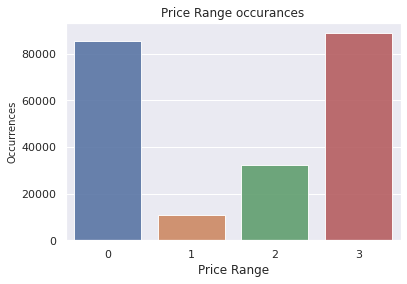

In [57]:
pRange_count = df4['price_rng_Cat'].value_counts()
sns.set(style="darkgrid")
sns.barplot(pRange_count.index, pRange_count.values, alpha=0.9)
plt.title('Price Range occurances')
plt.ylabel('Occurrences', fontsize=10)
plt.xlabel('Price Range', fontsize=12)
plt.show()

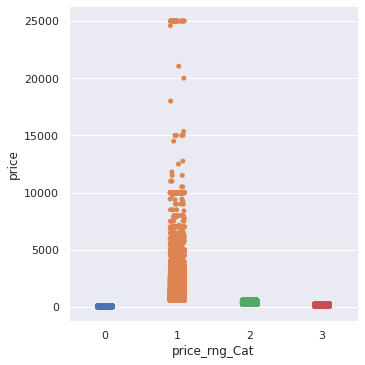

In [58]:
sns.catplot(x='price_rng_Cat', y='price', data=df4)

In [59]:
#KNN Regression 
knn = KNeighborsRegressor(algorithm='auto')
cols = df4[['calculated_host_listings_count', 'room_type_Cat']].values

X2=cols
Y2=df4['price_rng_Cat'].values

In [60]:
#normalize 
X_normalized = preprocessing.normalize(X2, norm='max')
X_normalized

array([[0.5, 1. ],
       [1. , 0. ],
       [1. , 0. ],
       ...,
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ]])

In [61]:
# Split into training and test  
X_train, X_test, y_train, y_test = train_test_split( 
             X_normalized, Y2, test_size = 0.3) 

#fit the model
knn.fit(X_train, y_train)

KNeighborsRegressor()

In [62]:
# Predicted class
y_pred4=knn.predict(X_test)

In [63]:
KNNreg = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred4.flatten()})
KNNreg

Actual  Predicted
0           0        2.0
1           3        2.0
2           3        2.0
3           3        2.0
4           0        2.0
...       ...        ...
65106       1        2.0
65107       3        2.0
65108       3        1.2
65109       3        2.0
65110       1        2.0

[65111 rows x 2 columns]

In [64]:
KNNreg['squared_error'] = (KNNreg['Predicted'] - KNNreg['Actual'])**(2)
mse = KNNreg['squared_error'].mean()
rmse2 = mse ** (1/2)
rmse2

1.245473134876376

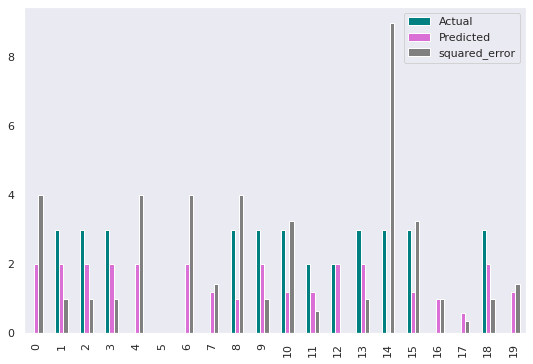

In [65]:
#comparison 
first20preds4=KNNreg.head(20)
c2='teal', 'orchid','gray'
first20preds4.plot(kind='bar',figsize=(9,6), color=c2)
plt.grid(which='major', linestyle='-', linewidth='0.3', color='goldenrod')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

The above KNN regresion is not optimal to predict price or price range.   
Changing parameters did not improve performance.

4- Decision Tree

In [66]:
Treedf=df4[[ 'minimum_nights', 'availability_365', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count', 'room_type_Cat',
       'city_Cat', 'state_Cat', 'price_rng_Cat']]

In [67]:
##Decision Tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import plot_tree

#split dataset in features and target variable
feature_cols = ['room_type_Cat', 'calculated_host_listings_count']
X = Treedf[feature_cols].values # Features
y = Treedf.price_rng_Cat.values # Target variable

In [68]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                   random_state = 5)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [69]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train_scaled,y_train)

#Predict the response for test dataset
y_pred6 = clf.predict(X_test)

In [70]:
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred6))

Accuracy: 0.5861682357819723


In [71]:
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred6)))

Root Mean Squared Error: 1.5211642938133643


In [72]:
Treecls = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred6.flatten()})
Treecls

Actual  Predicted
0           0          3
1           0          0
2           0          0
3           3          3
4           0          0
...       ...        ...
65106       1          3
65107       2          3
65108       2          3
65109       0          0
65110       2          3

[65111 rows x 2 columns]

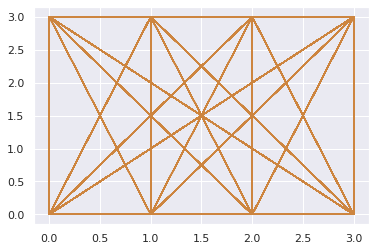

In [73]:
a=Treecls.Actual
b=Treecls.Predicted
plt.plot(a, b, color='peru', linewidth=1)
plt.show()


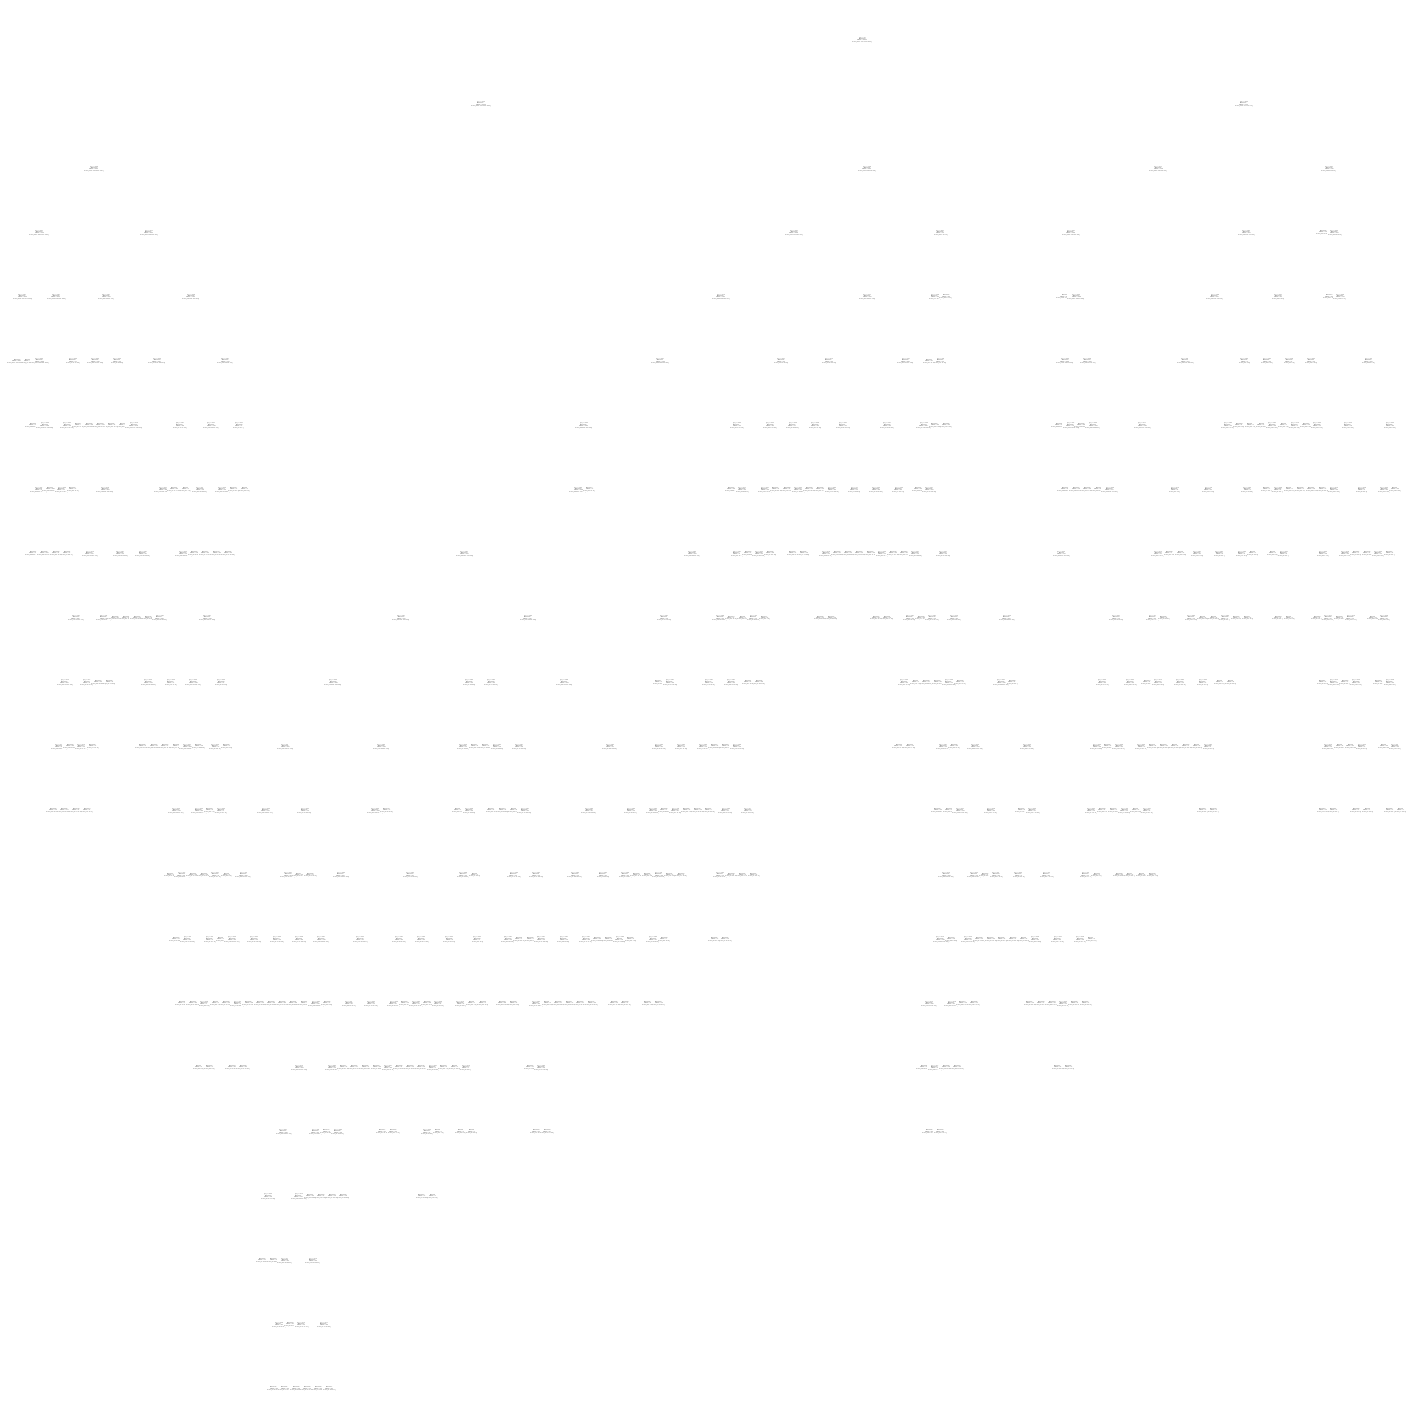

In [74]:
#plot tree
fig = plt.figure(figsize=(25,26))
_ = tree.plot_tree(clf)


In [75]:
##Results

KNNmod

Actual  Predicted
0           0          0
1           0          0
2           2          2
3           3          3
4           3          3
...       ...        ...
86809       1          1
86810       0          0
86811       3          3
86812       0          0
86813       3          3

[86814 rows x 2 columns]

In [76]:
df4.columns

Index(['id', 'minimum_nights', 'availability_365', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count', 'room_type_Cat',
       'city_Cat', 'state_Cat', 'price', 'price_rng_Cat'],
      dtype='object')

In [77]:
ids=df4[['id']]
ids

id
0          38585
1          80905
2         108061
3         155305
4         160594
...          ...
226025  45506143
226026  45511428
226027  45514685
226028  45516412
226029  45517735

[217035 rows x 1 columns]

In [78]:
df4.id.nunique()

217034

In [79]:
y_pred3.size

86814

In [80]:
# Predicted class
y_predALL=neigh.predict(X1)

In [81]:
y_predALL

array([3, 1, 0, ..., 3, 3, 3])

In [82]:
y_predALL.size

217035

In [83]:
sub = pd.DataFrame()
sub['Price_Range_Predicted'] = y_predALL

In [84]:
final=pd.concat([ids, sub], axis=1)
final

id  Price_Range_Predicted
0          38585.0                    3.0
1          80905.0                    1.0
2         108061.0                    0.0
3         155305.0                    3.0
4         160594.0                    3.0
...            ...                    ...
226025  45506143.0                    NaN
226026  45511428.0                    NaN
226027  45514685.0                    NaN
226028  45516412.0                    NaN
226029  45517735.0                    NaN

[225785 rows x 2 columns]

In [85]:
#nulls
final.isnull().sum().sum()


17500

In [86]:
final=final.dropna()
final

id  Price_Range_Predicted
0          38585.0                    3.0
1          80905.0                    1.0
2         108061.0                    0.0
3         155305.0                    3.0
4         160594.0                    3.0
...            ...                    ...
217030  31472206.0                    3.0
217031  31472860.0                    3.0
217032  31486619.0                    3.0
217033  31498642.0                    3.0
217034  31538755.0                    3.0

[208285 rows x 2 columns]

In [87]:



#join two dataframes
#answerSubm = pd.concat([ids, sub], axis=1)
#rename 0 to target

#answerSubm=answerSubm.rename(columns={0: "target"})

#answerSubm